In [51]:
# import all the libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter

In [52]:
# gpu usage
torch.cuda.is_available()

False

In [53]:
# import the dataset 
data = pd.read_csv('./MMdata.csv')
data_original = data.copy()

In [54]:
data.shape

(19484, 98)

In [55]:
#make 5 copies of each row for using for self-supervision
data_original = np.array(data_original)
data_original = np.repeat(data_original, repeats=5, axis=0)

In [56]:
data_original = pd.DataFrame(data_original)
#data_original = data_original.to_csv('./data_new.csv')

In [57]:
# drop the nas and reset index and Quality columns
data = data.dropna()

In [60]:
# Get all the features 
data = pd.DataFrame(data)
Quality = data.iloc[:, -1]

In [61]:
data.columns = data_original.columns
#data = data.drop(['Quality'], axis = 1)

In [62]:
data

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,179.08,3055.142,27.0,1.500000,34.52,43.0,95.01392,29.41720,0.787498,56.47257,...,153569.0,170236.0,178610.0,0.116788,0.000712,-1.993775,-0.006603,1.403689,-0.001574,1
5,220.16,3042.356,37.0,1.237499,34.07,43.2,94.71411,29.61720,0.849999,60.74240,...,153278.0,169905.0,178279.0,51.337479,0.157384,13.864785,0.023139,9.124539,0.011357,2
6,220.16,3042.356,37.0,1.237499,34.07,43.2,94.71411,29.61720,0.849999,60.74240,...,153278.0,169905.0,178279.0,49.346500,0.151293,10.969676,0.017709,2.632476,0.000484,1
7,178.75,3080.730,42.0,1.312500,33.67,43.2,94.93970,29.61720,0.774998,61.99442,...,152973.0,169576.0,177955.0,5.096756,0.015944,-0.287779,-0.003404,3.141537,0.001336,1
8,178.65,3071.981,34.0,1.462498,34.12,43.1,95.43774,29.51721,0.725000,38.27238,...,152871.0,169583.0,177950.0,27.753040,0.085244,10.691397,0.017188,16.297215,0.023372,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9558,189.57,3012.240,30.0,1.212498,33.97,43.4,93.84644,29.81721,0.675000,61.34911,...,166751.0,180397.0,188697.0,30.721352,0.094324,12.779609,0.021104,26.086159,0.039767,4
9559,189.57,3012.240,30.0,1.212498,33.97,43.4,93.84644,29.81721,0.675000,61.34911,...,166751.0,180397.0,188697.0,0.028498,0.000442,0.238046,-0.002417,1.690350,-0.001094,1
9560,191.65,3056.628,33.0,1.174999,34.33,43.5,93.91016,29.91720,0.612499,58.67612,...,169297.0,183023.0,191344.0,2.345815,0.007530,5.082227,0.006668,11.262484,0.014938,1
9561,191.65,3056.628,33.0,1.174999,34.33,43.5,93.91016,29.91720,0.612499,58.67612,...,169297.0,183023.0,191344.0,2.345815,0.007530,5.082227,0.006668,11.262484,0.014938,1


In [63]:
data = data.iloc[:, :-1]

In [64]:
# normalize the dataset using stdscaler/MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data_norm = scaler.transform(data)

In [65]:
data_norm = pd.DataFrame(data_norm)

In [66]:
data_norm = data_norm.reset_index()

In [67]:
data_norm.shape, data_norm.min(), data_norm.max()

((2630, 98),
 index    0.0
 0        0.0
 1        0.0
 2        0.0
 3        0.0
         ... 
 92       0.0
 93       0.0
 94       0.0
 95       0.0
 96       0.0
 Length: 98, dtype: float64,
 index    2629.0
 0           1.0
 1           1.0
 2           1.0
 3           1.0
           ...  
 92          1.0
 93          1.0
 94          1.0
 95          1.0
 96          1.0
 Length: 98, dtype: float64)

In [68]:
data_norm = data_norm.drop(['index'], axis = 1)

In [69]:
data_norm

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.007265,0.974576,0.003033,0.017742,0.771739,0.470588,0.005161,0.470585,0.988867,0.717924,...,0.509580,0.382647,0.776922,0.451033,0.002309,0.002310,0.010015,0.010015,0.017086,0.017088
1,0.701301,0.968310,0.008089,0.011828,0.608696,0.588235,0.004664,0.588232,0.990294,0.790885,...,0.508959,0.381922,0.775411,0.450197,0.080821,0.080822,0.049354,0.049354,0.032994,0.032995
2,0.701301,0.968310,0.008089,0.011828,0.608696,0.588235,0.004664,0.588232,0.990294,0.790885,...,0.508959,0.381922,0.775411,0.450197,0.077769,0.077770,0.042172,0.042172,0.019618,0.019619
3,0.001689,0.987116,0.010617,0.013517,0.463768,0.588235,0.005038,0.588232,0.988581,0.812279,...,0.507705,0.381162,0.773910,0.449379,0.009943,0.009943,0.014247,0.014246,0.020666,0.020668
4,0.000000,0.982828,0.006572,0.016897,0.626812,0.529412,0.005863,0.529415,0.987439,0.406927,...,0.507631,0.380908,0.773942,0.449366,0.044670,0.044671,0.041482,0.041483,0.047772,0.047774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,0.184491,0.953552,0.004550,0.011264,0.572464,0.705882,0.003227,0.705884,0.986297,0.801253,...,0.540225,0.415493,0.823295,0.476505,0.049220,0.049221,0.046662,0.046663,0.067941,0.067943
2626,0.184491,0.953552,0.004550,0.011264,0.572464,0.705882,0.003227,0.705884,0.986297,0.801253,...,0.540225,0.415493,0.823295,0.476505,0.002174,0.002175,0.015551,0.015552,0.017676,0.017678
2627,0.219632,0.975304,0.006067,0.010420,0.702899,0.764706,0.003333,0.764701,0.984870,0.755578,...,0.548338,0.421837,0.835279,0.483189,0.005726,0.005726,0.027568,0.027569,0.037399,0.037400
2628,0.219632,0.975304,0.006067,0.010420,0.702899,0.764706,0.003333,0.764701,0.984870,0.755578,...,0.548338,0.421837,0.835279,0.483189,0.005726,0.005726,0.027568,0.027569,0.037399,0.037400


In [70]:
Quality = Quality.reset_index()

In [71]:
Quality = Quality.drop(['index'], axis = 1)

In [72]:
Quality

,Quality
0,1
1,2
2,1
3,1
4,3
...,...
2625,4
2626,1
2627,1
2628,1


In [73]:
# Below is the final transformed dataset with the quality levels
data_norm = pd.concat([data_norm,Quality], axis = 1)

In [74]:
data_norm

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,Quality
0,0.007265,0.974576,0.003033,0.017742,0.771739,0.470588,0.005161,0.470585,0.988867,0.717924,...,0.382647,0.776922,0.451033,0.002309,0.002310,0.010015,0.010015,0.017086,0.017088,1
1,0.701301,0.968310,0.008089,0.011828,0.608696,0.588235,0.004664,0.588232,0.990294,0.790885,...,0.381922,0.775411,0.450197,0.080821,0.080822,0.049354,0.049354,0.032994,0.032995,2
2,0.701301,0.968310,0.008089,0.011828,0.608696,0.588235,0.004664,0.588232,0.990294,0.790885,...,0.381922,0.775411,0.450197,0.077769,0.077770,0.042172,0.042172,0.019618,0.019619,1
3,0.001689,0.987116,0.010617,0.013517,0.463768,0.588235,0.005038,0.588232,0.988581,0.812279,...,0.381162,0.773910,0.449379,0.009943,0.009943,0.014247,0.014246,0.020666,0.020668,1
4,0.000000,0.982828,0.006572,0.016897,0.626812,0.529412,0.005863,0.529415,0.987439,0.406927,...,0.380908,0.773942,0.449366,0.044670,0.044671,0.041482,0.041483,0.047772,0.047774,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,0.184491,0.953552,0.004550,0.011264,0.572464,0.705882,0.003227,0.705884,0.986297,0.801253,...,0.415493,0.823295,0.476505,0.049220,0.049221,0.046662,0.046663,0.067941,0.067943,4
2626,0.184491,0.953552,0.004550,0.011264,0.572464,0.705882,0.003227,0.705884,0.986297,0.801253,...,0.415493,0.823295,0.476505,0.002174,0.002175,0.015551,0.015552,0.017676,0.017678,1
2627,0.219632,0.975304,0.006067,0.010420,0.702899,0.764706,0.003333,0.764701,0.984870,0.755578,...,0.421837,0.835279,0.483189,0.005726,0.005726,0.027568,0.027569,0.037399,0.037400,1
2628,0.219632,0.975304,0.006067,0.010420,0.702899,0.764706,0.003333,0.764701,0.984870,0.755578,...,0.421837,0.835279,0.483189,0.005726,0.005726,0.027568,0.027569,0.037399,0.037400,1


In [75]:
#data_norm.to_csv('./data_copy.csv')

In [24]:
#data_norm.columns = data_original.columns

In [25]:
# transform into a numpy array and check for any na values
data_norm = np.array(data_norm)

In [26]:
np.all(np.isnan(data_norm))

False

In [27]:
# define X and y
X = data_norm[:, :-1]

In [28]:
y = data_norm[:, -1]

In [29]:
data_norm.shape

(2630, 98)

In [30]:
# define the indicator matrix of ones and zeros to mark the missing entries in the data
hadamard = np.ones(X.shape)

In [31]:
# mask entries in the dataset. Mark entries in either a MAR or NMAR manner depending on the mechanism of missingness present in the dataset.
import random
def mask_randomly(X):
    #hadamard_train = np.ones(X.shape)
    block_size = 8
    row_rand_list = list(np.random.randint(0, (X.shape[0]-block_size), 100))
    col_rand_list = []
    for i in row_rand_list:
        col_rand = random.randint(0, X.shape[1]-block_size)
        col_rand_list.append(col_rand)
        for j in range(block_size):
            for k in range(block_size):
                X[i+j][col_rand+k] = -1 
    #hadamard_train = np.where(data == -1, 0, hadamard_train)
    return X

In [32]:
# split into train, val and test sets for original dataset as well as indicator matrix
X_train, X_test, y_train, y_test, hadamard_train, hadamard_test = train_test_split(X, y, hadamard,test_size=0.33,shuffle=True)
X_train, X_val, y_train, y_val, hadamard_train, hadamard_val = train_test_split(X_train, y_train, hadamard_train, test_size=0.01 ,shuffle=True)

In [33]:
# keep the originals for metric calcultaion
X_train_original = X_train.copy()
X_val_original = X_val.copy()
X_test_original = X_test.copy()

In [34]:
# incomplete dataset
X_train_inc = mask_randomly(X_train)

In [35]:
# define the different percentage of deletion code - this is another mechanism of missingness 
def codefordeletion(data, hadamard, frac):
    [Rn, Cn] = data.shape
    ind = []
    for i in range(Rn):
        for j in range(Cn):
            ind.append(data[i, j])
    fraction = frac
        # calculate entries to be deleted
    rem_num = ((len(ind)) * fraction / 100)  # total number of entries to be removed
        # has to be an integer value
    rem_num = int(rem_num)
        # select random elements from the upper triangle:
    indices = np.random.choice(len(ind), rem_num, replace=False)
        # make these indices -1
    for i in indices:
        ind[i] = -1  # now place these values back in the upper triangle:
    #print(ind)
    p = 0
    for i in range(Rn):
        for j in range(Cn):
            data[i, j] = ind[p]
            p += 1
    print(data)
    print(hadamard)
    hadamard = np.where(data == -1, 0, hadamard)
    return data, hadamard

In [36]:
X_train.shape

(1744, 97)

In [37]:
# define corresponding hadamard for train, validation and test sets
hadamard_train = np.ones(X_train.shape)

In [38]:
#X_train_inc, hadamard_train = codefordeletion(X_train, hadamard_train, 20)

In [39]:
X_train.shape, hadamard_train.shape

((1744, 97), (1744, 97))

In [40]:
hadamard_train = np.where(X_train_inc == -1, 0, hadamard_train)

In [41]:
#hadamard_train = pd.DataFrame(hadamard_train)
#hadamard_train.to_csv('had_new.csv')

In [42]:
#X_train_inc, hadamard_train  = codefordeletion(X_train, hadamard_train, 60)

In [43]:
#X_train_inc = pd.DataFrame(X_train_inc)
#X_train_inc.to_csv('./X_train_inc1.csv')

In [44]:
X_train_inc = np.where(X_train_inc == -1, np.nan, X_train_inc)

In [45]:
#hadamard_train = pd.DataFrame(hadamard_train)
#hadamard_train.to_csv('./hadamard1.csv')

In [46]:
print(X_train_inc)

#Obtain mean of columns as you need, nanmean is convenient.
col_mean_train = np.nanmean(X_train_inc, axis=0)

print(col_mean_train)

#Find indices that you need to replace
inds = np.where(np.isnan(X_train_inc))

#Place column means in the indices. Align the arrays using take
X_train_inc[inds] = np.take(col_mean_train, inds[1])

print(X_train_inc)

[[0.05254266 0.97018372 0.00859454 ... 0.07080077 0.02524302 0.0252446 ]
 [0.0231458  0.97146621 0.00808898 ... 0.01497934 0.01441126 0.01441239]
 [0.02263896 0.97397434 0.01112235 ... 0.05627722 0.02139411 0.02139518]
 ...
 [0.02804528 0.95423714 0.00758342 ... 0.03724508 0.1614563  0.16145774]
 [0.0231458  0.97115306 0.00808898 ... 0.01135153 0.01751526 0.01751713]
 [0.04223686 0.96130088 0.01921132 ... 0.00628245 0.01368477 0.0136849 ]]
[0.04804666 0.96481805 0.00925722 0.01645469 0.57209092 0.53869787
 0.0032987  0.53868795 0.98752393 0.80163049 0.50679878 0.95853193
 0.99243418 0.99482415 0.98343534 0.98615918 0.07259096 0.05855294
 0.24010312 0.67690499 0.58371913 0.86348241 0.57878425 0.8628075
 0.51550033 0.80423729 0.52904469 0.50663998 0.56612933 0.49887072
 0.73222749 0.93608718 0.44044811 0.80914729 0.00170603 0.84074666
 0.98805048 0.12919405 0.45836304 0.43566416 0.45850325 0.43550836
 0.40509038 0.40900912 0.40510811 0.39554314 0.46766188 0.42624567
 0.46774864 0.4262006

In [47]:
X_train_inc.shape

(1744, 97)

In [48]:
# Do the same for the validation test
#X_val_inc, hadamard_val = codefordeletion(X_val, hadamard_val, 20)
#X_val_inc = np.where(X_val_inc == -1, np.nan, X_val_inc)

In [49]:
# similarly for the validation and test sets
X_val_inc = mask_randomly(X_val)

In [50]:
hadamard_val = np.ones(X_val_inc.shape)

In [51]:
hadamard_val = np.where(X_val_inc == -1, 0, hadamard_val)

In [52]:
X_val_inc = np.where(X_val_inc == -1, np.nan, X_val_inc)

In [53]:
# replace all missing entries with mean values
print(X_val_inc)

#Obtain mean of columns as you need, nanmean is convenient.
col_mean_val = np.nanmean(X_val_inc, axis=0)

print(col_mean_val)

#Find indices that you need to replace
inds = np.where(np.isnan(X_val_inc))

#Place column means in the indices. Align the arrays using take
X_val_inc[inds] = np.take(col_mean_val, inds[1])

print(X_val_inc)

[[0.02551107 0.95446649 0.00202224 ...        nan 0.015482   0.01548358]
 [0.05102213 0.96944079 0.00556117 ...        nan        nan        nan]
 [0.04460213 0.96310528 0.02426694 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [0.06082108 0.96680034 0.00808898 ... 0.06886676 0.06827416 0.06827555]]
[0.04906234 0.96201391 0.00970677 0.01605183 0.44710145 0.52941176
 0.00232222 0.52941306 0.98886667 0.89712677 0.47868153 0.96035372
 0.99242927 0.99456946 0.98591946 0.98444763 0.06455346 0.04409819
 0.02784145 0.73718238 0.03219578 0.93987069 0.05115922 0.93746003
 0.31818182 0.8962963  0.5        0.35714286 0.70223325 0.60169492
 0.75       0.94323232 0.         0.83344437 0.00156954 0.85370185
 0.99753998 0.13588337 0.46434307 0.44138858 0.45769653 0.43462863
 0.40419603 0.40818815 0.40413038 0.40140908 0.47381724 0.43215149
 0.47387928 0.432098

In [54]:
y_train = np.array(y_train)
y_train = np.repeat(y_train, repeats=10, axis=0)

In [55]:
y_val = np.array(y_val)
y_val = np.repeat(y_val, repeats=10, axis=0)

In [56]:
# make copies of the train and validation sets
X_train_inc = np.array(X_train_inc)
X_train_inc = np.repeat(X_train_inc, repeats=10, axis=0)

In [57]:
X_train_inc.shape

(17440, 97)

In [58]:
# Do the same for the test set
#X_test_inc, hadamard_test = codefordeletion(X_test, hadamard_test, 20)

In [59]:
# make copies of the train and validation sets
X_val_inc = np.array(X_val_inc)
X_val_inc = np.repeat(X_val_inc, repeats=10, axis=0)

In [60]:
hadamard_train = np.array(hadamard_train)
hadamard_train = np.repeat(hadamard_train, repeats=10, axis=0)

In [61]:
hadamard_val = np.array(hadamard_val)
hadamard_val = np.repeat(hadamard_val, repeats=10, axis=0)

In [62]:
X_train_original = np.array(X_train_original)
X_train_original = np.repeat(X_train_original, repeats=10, axis=0)
X_val_original = np.array(X_val_original)
X_val_original = np.repeat(X_val_original, repeats=10, axis=0)


In [63]:
X_test_inc = mask_randomly(X_test)

In [64]:
hadamard_test = np.ones(X_test.shape)

In [65]:
#X_test_inc, hadamard_test = codefordeletion(X_test, hadamard_test, 20)

In [66]:
hadamard_test = np.where(X_test_inc == -1, 0, hadamard_test)

In [67]:
X_test_inc = np.where(X_test_inc == -1, np.nan, X_test_inc)

In [68]:
print(X_test_inc)
#Obtain mean of columns as you need, nanmean is convenient.
col_mean_test = np.nanmean(X_test_inc, axis=0)

print(col_mean_test)

#Find indices that you need to replace
inds = np.where(np.isnan(X_test_inc))

#Place column means in the indices. Align the arrays using take
X_test_inc[inds] = np.take(col_mean_test, inds[1])

print(X_test_inc)

[[0.0562595  0.96456076 0.00353893 ... 0.01459746 0.0210038  0.02100566]
 [0.02111843 0.96867286 0.00758342 ... 0.02748881 0.03512953 0.03513164]
 [0.01875317 0.97000534 0.00859454 ... 0.01978356 0.10908207 0.10908393]
 ...
 [0.03683055 0.96825239 0.00808898 ... 0.01424638 0.02249363 0.02249502]
 [0.01909106 0.98209661 0.00505561 ... 0.02039333 0.02990592 0.02990743]
 [0.02432843 0.96001741 0.00960566 ... 0.03241006 0.05609534 0.0560972 ]]
[0.04734973 0.96570822 0.00862644 0.01561285 0.57589414 0.54436057
 0.00274123 0.5443599  0.98815461 0.79709098 0.51016666 0.959799
 0.99303599 0.99538098 0.98427123 0.98688915 0.07105292 0.0589701
 0.2398801  0.6733202  0.59017602 0.85614343 0.58561507 0.85370814
 0.50890538 0.79904602 0.5259833  0.50399347 0.56133714 0.49750378
 0.72515625 0.93583586 0.45335821 0.80793774 0.00366606 0.83858948
 0.98719795 0.12919153 0.45781271 0.43509641 0.45792564 0.43498214
 0.40469467 0.40863336 0.4047446  0.39517614 0.46713401 0.42576879
 0.46713167 0.42561783 

In [69]:
X_train_inc.shape

(17440, 97)

In [70]:
# Now these are the targets for training the network
X_train_target = X_train_inc.copy()
X_val_target = X_val_inc.copy()
X_test_target = X_test_inc.copy()

In [71]:
col_mean_test = list(col_mean_test)
col_mean_train = list(col_mean_train)
col_mean_val = list(col_mean_val)

In [72]:
# Now define the inputs
X_train_inputs = X_train_target.copy()
X_val_inputs = X_val_target.copy()
X_test_inputs = X_test_target.copy()

In [73]:
X_train_target.shape

(17440, 97)

In [74]:
# define the different percentage of deletion code - This is for missing at random as was done until now. 
def codefordeletion2(data, hadamards,  frac):
    [Rn, Cn] = data.shape
    ind = []
    for i in range(Rn):
        for j in range(Cn):
            ind.append(data[i, j])
    fraction = frac
        # calculate entries to be deleted
    rem_num = ((len(ind)) * fraction / 100)  # total number of entries to be removed
        # has to be an integer value
    rem_num = int(rem_num)
        # select random elements from the upper triangle:
    indices = np.random.choice(len(ind), rem_num, replace=False)
        # make these indices -1
    # check hadamards of corresponding indices
    had = []
    for i in range(Rn):
        for j in range(Cn):
            had.append(hadamards[i, j])
    for i in indices:
        #if ind[i] not in col_mean:
        if had[i] != 0:
            ind[i] = -1  # now place these values back in the upper triangle:
    #print(ind)
    p = 0
    for i in range(Rn):
        for j in range(Cn):
            data[i, j] = ind[p]
            p += 1
    #print(data)
    return data

In [75]:
def mask_randomly2(X, hadamard):
    #hadamard_train = np.ones(X.shape)
    block_size = 8
    row_rand_list = list(np.random.randint(0, (X.shape[0]-block_size), 30))
    col_rand_list = []
    for i in row_rand_list:
        col_rand = random.randint(0, X.shape[1]-block_size)
        col_rand_list.append(col_rand)
        for j in range(block_size):
            for k in range(block_size):
                if hadamard[i+j][col_rand+k] != 0:
                    X[i+j][col_rand+k] = -1
    return X

In [76]:
X_train_inputs = codefordeletion2(X_train_inputs, hadamard_train, 0)

In [77]:
#X_train_inputs = mask_randomly2(X_train_inputs, hadamard_train)


In [78]:
X_train_inputs = np.where(X_train_inputs == -1, np.nan, X_train_inputs)

In [79]:
print(X_train_inputs)

#Obtain mean of columns as you need, nanmean is convenient.
col_mean = np.nanmean(X_train_inputs, axis=0)

print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(X_train_inputs))

#Place column means in the indices. Align the arrays using take
X_train_inputs[inds] = np.take(col_mean, inds[1])

print(X_train_inputs)

[[0.05254266 0.97018372 0.00859454 ... 0.07080077 0.02524302 0.0252446 ]
 [0.05254266 0.97018372 0.00859454 ... 0.07080077 0.02524302 0.0252446 ]
 [0.05254266 0.97018372 0.00859454 ... 0.07080077 0.02524302 0.0252446 ]
 ...
 [0.04223686 0.96130088 0.01921132 ... 0.00628245 0.01368477 0.0136849 ]
 [0.04223686 0.96130088 0.01921132 ... 0.00628245 0.01368477 0.0136849 ]
 [0.04223686 0.96130088 0.01921132 ... 0.00628245 0.01368477 0.0136849 ]]
[0.04804666 0.96481805 0.00925722 0.01645469 0.57209092 0.53869787
 0.0032987  0.53868795 0.98752393 0.80163049 0.50679878 0.95853193
 0.99243418 0.99482415 0.98343534 0.98615918 0.07259096 0.05855294
 0.24010312 0.67690499 0.58371913 0.86348241 0.57878425 0.8628075
 0.51550033 0.80423729 0.52904469 0.50663998 0.56612933 0.49887072
 0.73222749 0.93608718 0.44044811 0.80914729 0.00170603 0.84074666
 0.98805048 0.12919405 0.45836304 0.43566416 0.45850325 0.43550836
 0.40509038 0.40900912 0.40510811 0.39554314 0.46766188 0.42624567
 0.46774864 0.4262006

In [80]:
# Do the same for the validation test
X_val_inputs = codefordeletion2(X_val_inputs, hadamard_val, 0)
#X_val_inputs = mask_randomly2(X_val_inputs, hadamard_val)
X_val_inputs = np.where(X_val_inputs == -1, np.nan, X_val_inputs)

In [81]:
print(X_val_inputs)

#Obtain mean of columns as you need, nanmean is convenient.
col_mean = np.nanmean(X_val_inputs, axis=0)

print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(X_val_inputs))

#Place column means in the indices. Align the arrays using take
X_val_inputs[inds] = np.take(col_mean, inds[1])

print(X_val_inputs)

[[0.02551107 0.95446649 0.00202224 ... 0.06886676 0.015482   0.01548358]
 [0.02551107 0.95446649 0.00202224 ... 0.06886676 0.015482   0.01548358]
 [0.02551107 0.95446649 0.00202224 ... 0.06886676 0.015482   0.01548358]
 ...
 [0.06082108 0.96680034 0.00808898 ... 0.06886676 0.06827416 0.06827555]
 [0.06082108 0.96680034 0.00808898 ... 0.06886676 0.06827416 0.06827555]
 [0.06082108 0.96680034 0.00808898 ... 0.06886676 0.06827416 0.06827555]]
[0.04906234 0.96201391 0.00970677 0.01605183 0.44710145 0.52941176
 0.00232222 0.52941306 0.98886667 0.89712677 0.47868153 0.96035372
 0.99242927 0.99456946 0.98591946 0.98444763 0.06455346 0.04409819
 0.02784145 0.73718238 0.03219578 0.93987069 0.05115922 0.93746003
 0.31818182 0.8962963  0.5        0.35714286 0.70223325 0.60169492
 0.75       0.94323232 0.         0.83344437 0.00156954 0.85370185
 0.99753998 0.13588337 0.46434307 0.44138858 0.45769653 0.43462863
 0.40419603 0.40818815 0.40413038 0.40140908 0.47381724 0.43215149
 0.47387928 0.432098

In [82]:
'''
X_train_inputs = pd.DataFrame(X_train_inputs)
X_train_target = pd.DataFrame(X_train_target)
hadamard_train = pd.DataFrame(hadamard_train)
X_train_inputs.to_csv('inputs.csv')
X_train_target.to_csv('targets.csv')
hadamard_train.to_csv('hadamard.csv')
'''

"\nX_train_inputs = pd.DataFrame(X_train_inputs)\nX_train_target = pd.DataFrame(X_train_target)\nhadamard_train = pd.DataFrame(hadamard_train)\nX_train_inputs.to_csv('inputs.csv')\nX_train_target.to_csv('targets.csv')\nhadamard_train.to_csv('hadamard.csv')\n"

In [83]:
# Do the same for the test set
#X_test_inputs = codefordeletion2(X_test_inputs, hadamard_test, 20)

In [84]:
#X_test_inputs = np.where(X_test_inputs == -1, np.nan, X_test_inputs)

In [85]:
#print(X_test_inputs)
'''
#Obtain mean of columns as you need, nanmean is convenient.
col_mean = np.nanmean(X_test_inputs, axis=0)

print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(X_test_inputs))

#Place column means in the indices. Align the arrays using take
X_test_inputs[inds] = np.take(col_mean, inds[1])

print(X_test_inputs)
'''

'\n#Obtain mean of columns as you need, nanmean is convenient.\ncol_mean = np.nanmean(X_test_inputs, axis=0)\n\nprint(col_mean)\n\n#Find indices that you need to replace\ninds = np.where(np.isnan(X_test_inputs))\n\n#Place column means in the indices. Align the arrays using take\nX_test_inputs[inds] = np.take(col_mean, inds[1])\n\nprint(X_test_inputs)\n'

In [86]:
# define the dataset
class MMData(Dataset):
    def __init__(self, X_input, X_target, X_original, hadamard):
        self.X_input = X_input.copy()
        self.X_target = X_target.copy()
        self.X_original = X_original.copy()
        self.hadamard = hadamard.copy()
        
    def __len__(self):
        return len(self.X_input)
    
    def __getitem__(self, idx):
        return self.X_input[idx], self.X_target[idx], self.X_original[idx], self.hadamard[idx]

In [87]:
# define the autoencoder architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.fc1 = nn.Linear(97, 45)
        self.fc2 = nn.Linear(45, 16)
        self.fc3 = nn.Linear(16, 45)
        self.fc4 = nn.Linear(45, 97)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h2 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h2))

    def forward(self, x):
        z = self.encode(x.view(-1, 97))
        return self.decode(z)

In [88]:
# define the autoencoder architecture
'''
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.fc1 = nn.Linear(97, 34)
        self.fc2 = nn.Linear(34, 8)
        self.fc3 = nn.Linear(8, 34)
        self.fc4 = nn.Linear(34, 97)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h2 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h2))

    def forward(self, x):
        z = self.encode(x.view(-1, 97))
        return self.decode(z)
'''

'\nclass AutoEncoder(nn.Module):\n    def __init__(self):\n        super(AutoEncoder, self).__init__()\n\n        self.fc1 = nn.Linear(97, 34)\n        self.fc2 = nn.Linear(34, 8)\n        self.fc3 = nn.Linear(8, 34)\n        self.fc4 = nn.Linear(34, 97)\n\n    def encode(self, x):\n        h1 = F.relu(self.fc1(x))\n        return self.fc2(h1)\n\n    def decode(self, z):\n        h2 = F.relu(self.fc3(z))\n        return F.sigmoid(self.fc4(h2))\n\n    def forward(self, x):\n        z = self.encode(x.view(-1, 97))\n        return self.decode(z)\n'

In [89]:
#creating train and valid datasets
train_ds = MMData(X_train_inputs, X_train_target, X_train_original, hadamard_train)
valid_ds = MMData(X_val_inputs, X_val_target, X_val_original, hadamard_val)
test_ds = MMData(X_test_inputs, X_test_target, X_test_original, hadamard_test)

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size,shuffle=True)

In [90]:
# define the loss function
def loss_function(Y_hat, Y, Omega):
    loss = torch.sum(Omega*(Y_hat-Y)**2)
    return loss

In [91]:
# define the model and optimizer
model = AutoEncoder()
model.to('cuda:0')
optimizer = optim.Adam(list(model.parameters()), lr=1e-3)

In [92]:
# define the train and validation loops
def train(epoch):
    model.train()
    train_loss = 0
    preds_train = []
    orig_train = []
    hadamards_train = []
    for X_train_inputs, X_train_target, X_train_original, hadamard_train in tqdm(train_dl):
        X_train_inputs, X_train_target, X_train_original, hadamard_train = X_train_inputs.cuda(), X_train_target.cuda(), X_train_original.cuda(), hadamard_train.cuda()
        optimizer.zero_grad()
        recon = model(X_train_inputs.float())
        loss = loss_function(recon, X_train_target, hadamard_train)      
        loss.backward()
        train_loss += loss.item()
        optimizer.step() 
        if epoch == 200:
            preds_train.append(recon.cpu().detach().numpy())
            orig_train.append(X_train_original.cpu().detach().numpy())
            hadamards_train.append(hadamard_train.cpu().detach().numpy())            
    train_loss=train_loss/len(train_dl)
    train_losses.append(train_loss)
    print('Train Loss: %.3f'%(train_loss))
    return train_losses, preds_train, orig_train, hadamards_train

In [93]:
#define the validation epochs
def val(epoch):
    model.eval()
    running_loss=0
    preds_val = []
    orig_val = []
    hadamards_val = []
    with torch.no_grad():
        for X_val_inputs, X_val_target, X_val_original, hadamard_val in tqdm(valid_dl):
            X_val_inputs, X_val_target, X_val_original, hadamard_val = X_val_inputs.cuda(), X_val_target.cuda(), X_val_original.cuda(), hadamard_val.cuda()
            recon=model(X_val_inputs.float())
            loss = loss_function(recon, X_val_target, hadamard_val) 
            running_loss+=loss.item()
            if epoch == 200:
                preds_val.append(recon.cpu().detach().numpy())
                orig_val.append(X_val_original.cpu().detach().numpy())
                hadamards_val.append(hadamard_val.cpu().detach().numpy()) 
        eval_loss=running_loss/len(valid_dl)
        eval_losses.append(eval_loss)
    print('Validation Loss: %.3f' %(eval_loss))
    return eval_losses, preds_val, orig_val, hadamards_val

In [94]:
# run the train and val loops
epochs=200
train_losses = []
eval_losses = []
for epoch in range(1,epochs+1): 
    train_losses, preds_train, orig_train, hadamards_train = train(epoch)
    eval_losses, preds_val, orig_val, hadamards_val = val(epoch)

  0%|                                                                                          | 0/273 [00:00<?, ?it/s]C:\Users\16175\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  7%|█████▎                                                                          | 18/273 [00:00<00:01, 171.89it/s]

Train Loss: 98.745
Validation Loss: 4.719


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 28.971
Validation Loss: 3.854


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 200.53it/s]

Train Loss: 19.411
Validation Loss: 2.256


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.53it/s]

Train Loss: 16.207
Validation Loss: 2.202


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 198.45it/s]

Train Loss: 15.610
Validation Loss: 2.460


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 184.96it/s]

Train Loss: 15.102
Validation Loss: 2.531


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 190.99it/s]

Train Loss: 14.594
Validation Loss: 2.481


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.46it/s]

Train Loss: 13.684
Validation Loss: 2.417


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.74it/s]

Train Loss: 12.429
Validation Loss: 2.160


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 190.90it/s]

Train Loss: 10.680
Validation Loss: 1.522


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 200.54it/s]

Train Loss: 9.025
Validation Loss: 1.418


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 198.64it/s]

Train Loss: 7.501
Validation Loss: 1.103


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.26it/s]

Train Loss: 6.573
Validation Loss: 1.118


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.71it/s]

Train Loss: 6.191
Validation Loss: 1.140


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 184.96it/s]

Train Loss: 5.816
Validation Loss: 1.056


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 204.36it/s]

Train Loss: 5.370
Validation Loss: 0.985


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 198.55it/s]

Train Loss: 4.926
Validation Loss: 0.893


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.46it/s]

Train Loss: 4.612
Validation Loss: 0.832


  6%|████▋                                                                           | 16/273 [00:00<00:01, 154.21it/s]

Train Loss: 4.407
Validation Loss: 0.711


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.46it/s]

Train Loss: 4.235
Validation Loss: 0.753


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.46it/s]

Train Loss: 4.015
Validation Loss: 0.751


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.74it/s]

Train Loss: 3.740
Validation Loss: 0.696


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.77it/s]

Train Loss: 3.436
Validation Loss: 0.689


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 206.43it/s]

Train Loss: 3.256
Validation Loss: 0.664


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 179.72it/s]

Train Loss: 3.151
Validation Loss: 0.637


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.25it/s]

Train Loss: 3.057
Validation Loss: 0.547


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.69it/s]

Train Loss: 2.982
Validation Loss: 0.586


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 171.83it/s]

Train Loss: 2.893
Validation Loss: 0.492


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.82it/s]

Train Loss: 2.782
Validation Loss: 0.497


  6%|████▋                                                                           | 16/273 [00:00<00:01, 149.93it/s]

Train Loss: 2.647
Validation Loss: 0.490


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 204.43it/s]

Train Loss: 2.538
Validation Loss: 0.501


  6%|████▋                                                                           | 16/273 [00:00<00:01, 155.75it/s]

Train Loss: 2.475
Validation Loss: 0.468


  6%|████▉                                                                           | 17/273 [00:00<00:01, 160.76it/s]

Train Loss: 2.410
Validation Loss: 0.455


 15%|███████████▋                                                                    | 40/273 [00:00<00:01, 197.74it/s]

Train Loss: 2.360
Validation Loss: 0.474


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.46it/s]

Train Loss: 2.306
Validation Loss: 0.446


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 2.272
Validation Loss: 0.444


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 183.18it/s]

Train Loss: 2.229
Validation Loss: 0.434


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 200.47it/s]

Train Loss: 2.183
Validation Loss: 0.411


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.33it/s]

Train Loss: 2.136
Validation Loss: 0.399


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.11it/s]

Train Loss: 2.087
Validation Loss: 0.382


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.74it/s]

Train Loss: 2.020
Validation Loss: 0.387


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.71it/s]

Train Loss: 1.956
Validation Loss: 0.428


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 183.18it/s]

Train Loss: 1.912
Validation Loss: 0.433


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.62it/s]

Train Loss: 1.868
Validation Loss: 0.379


  6%|████▋                                                                           | 16/273 [00:00<00:01, 158.78it/s]

Train Loss: 1.832
Validation Loss: 0.393


 14%|███████████▏                                                                    | 38/273 [00:00<00:01, 189.55it/s]

Train Loss: 1.801
Validation Loss: 0.410


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 198.45it/s]

Train Loss: 1.779
Validation Loss: 0.391


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.79it/s]

Train Loss: 1.753
Validation Loss: 0.413


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 170.26it/s]

Train Loss: 1.729
Validation Loss: 0.374


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.94it/s]

Train Loss: 1.713
Validation Loss: 0.422


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.94it/s]

Train Loss: 1.694
Validation Loss: 0.403


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.23it/s]

Train Loss: 1.670
Validation Loss: 0.389


  5%|████                                                                            | 14/273 [00:00<00:01, 137.63it/s]

Train Loss: 1.640
Validation Loss: 0.388


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 187.40it/s]

Train Loss: 1.622
Validation Loss: 0.393


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.67it/s]

Train Loss: 1.599
Validation Loss: 0.387


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.75it/s]

Train Loss: 1.581
Validation Loss: 0.356


  5%|████▍                                                                           | 15/273 [00:00<00:01, 143.24it/s]

Train Loss: 1.558
Validation Loss: 0.369


  5%|████▍                                                                           | 15/273 [00:00<00:01, 146.01it/s]

Train Loss: 1.543
Validation Loss: 0.359


  5%|███▊                                                                            | 13/273 [00:00<00:02, 127.79it/s]

Train Loss: 1.527
Validation Loss: 0.304


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.56it/s]

Train Loss: 1.506
Validation Loss: 0.354


  6%|████▉                                                                           | 17/273 [00:00<00:01, 162.34it/s]

Train Loss: 1.490
Validation Loss: 0.350


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.11it/s]

Train Loss: 1.472
Validation Loss: 0.318


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 186.77it/s]

Train Loss: 1.452
Validation Loss: 0.332


 13%|██████████▌                                                                     | 36/273 [00:00<00:01, 178.65it/s]

Train Loss: 1.444
Validation Loss: 0.314


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 202.45it/s]

Train Loss: 1.435
Validation Loss: 0.324


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 1.414
Validation Loss: 0.325


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 173.48it/s]

Train Loss: 1.403
Validation Loss: 0.334


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.79it/s]

Train Loss: 1.384
Validation Loss: 0.326


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.34it/s]

Train Loss: 1.378
Validation Loss: 0.315


  5%|████▍                                                                           | 15/273 [00:00<00:01, 147.45it/s]

Train Loss: 1.367
Validation Loss: 0.315


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.94it/s]

Train Loss: 1.347
Validation Loss: 0.347


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 179.52it/s]

Train Loss: 1.343
Validation Loss: 0.279


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 179.45it/s]

Train Loss: 1.326
Validation Loss: 0.322


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.42it/s]

Train Loss: 1.313
Validation Loss: 0.294


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 168.62it/s]

Train Loss: 1.306
Validation Loss: 0.291


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 186.83it/s]

Train Loss: 1.289
Validation Loss: 0.276


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 190.99it/s]

Train Loss: 1.286
Validation Loss: 0.310


  6%|████▉                                                                           | 17/273 [00:00<00:01, 164.78it/s]

Train Loss: 1.278
Validation Loss: 0.285


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.28it/s]

Train Loss: 1.259
Validation Loss: 0.299


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.53it/s]

Train Loss: 1.248
Validation Loss: 0.295


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 184.19it/s]

Train Loss: 1.240
Validation Loss: 0.287


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.55it/s]

Train Loss: 1.232
Validation Loss: 0.288


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.69it/s]

Train Loss: 1.217
Validation Loss: 0.292


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 183.12it/s]

Train Loss: 1.203
Validation Loss: 0.283


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.17it/s]

Train Loss: 1.190
Validation Loss: 0.293


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.17it/s]

Train Loss: 1.173
Validation Loss: 0.303


  6%|████▋                                                                           | 16/273 [00:00<00:01, 152.74it/s]

Train Loss: 1.164
Validation Loss: 0.272


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.44it/s]

Train Loss: 1.147
Validation Loss: 0.290


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.50it/s]

Train Loss: 1.136
Validation Loss: 0.305


  6%|████▉                                                                           | 17/273 [00:00<00:01, 162.29it/s]

Train Loss: 1.125
Validation Loss: 0.271


  6%|████▋                                                                           | 16/273 [00:00<00:01, 158.84it/s]

Train Loss: 1.108
Validation Loss: 0.262


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.95it/s]

Train Loss: 1.102
Validation Loss: 0.239


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 180.88it/s]

Train Loss: 1.094
Validation Loss: 0.265


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.16it/s]

Train Loss: 1.083
Validation Loss: 0.227


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 185.52it/s]

Train Loss: 1.072
Validation Loss: 0.272


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.34it/s]

Train Loss: 1.063
Validation Loss: 0.254


  6%|████▉                                                                           | 17/273 [00:00<00:01, 163.84it/s]

Train Loss: 1.055
Validation Loss: 0.250


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.62it/s]

Train Loss: 1.047
Validation Loss: 0.225


  6%|████▉                                                                           | 17/273 [00:00<00:01, 163.84it/s]

Train Loss: 1.039
Validation Loss: 0.240


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.56it/s]

Train Loss: 1.029
Validation Loss: 0.228


 13%|██████████▌                                                                     | 36/273 [00:00<00:01, 180.72it/s]

Train Loss: 1.031
Validation Loss: 0.253


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.04it/s]

Train Loss: 1.020
Validation Loss: 0.236


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.86it/s]

Train Loss: 1.015
Validation Loss: 0.239


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.63it/s]

Train Loss: 1.006
Validation Loss: 0.222


  5%|████▍                                                                           | 15/273 [00:00<00:01, 147.41it/s]

Train Loss: 1.001
Validation Loss: 0.231


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 0.996
Validation Loss: 0.241


 14%|███████████▍                                                                    | 39/273 [00:00<00:01, 190.95it/s]

Train Loss: 0.986
Validation Loss: 0.237


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.44it/s]

Train Loss: 0.983
Validation Loss: 0.243


 14%|███████████▏                                                                    | 38/273 [00:00<00:01, 183.73it/s]

Train Loss: 0.976
Validation Loss: 0.248


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 0.967
Validation Loss: 0.237


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.77it/s]

Train Loss: 0.969
Validation Loss: 0.233


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 170.27it/s]

Train Loss: 0.960
Validation Loss: 0.230


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.18it/s]

Train Loss: 0.951
Validation Loss: 0.257


  6%|████▉                                                                           | 17/273 [00:00<00:01, 166.23it/s]

Train Loss: 0.944
Validation Loss: 0.277


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.63it/s]

Train Loss: 0.942
Validation Loss: 0.218


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 177.79it/s]

Train Loss: 0.934
Validation Loss: 0.251


 13%|██████████▌                                                                     | 36/273 [00:00<00:01, 179.64it/s]

Train Loss: 0.925
Validation Loss: 0.238


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.56it/s]

Train Loss: 0.922
Validation Loss: 0.251


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.60it/s]

Train Loss: 0.914
Validation Loss: 0.246


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.69it/s]

Train Loss: 0.910
Validation Loss: 0.247


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 170.87it/s]

Train Loss: 0.904
Validation Loss: 0.230


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 195.63it/s]

Train Loss: 0.890
Validation Loss: 0.258


 14%|███████████▍                                                                    | 39/273 [00:00<00:01, 193.68it/s]

Train Loss: 0.894
Validation Loss: 0.223


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 201.47it/s]

Train Loss: 0.889
Validation Loss: 0.241


  6%|████▉                                                                           | 17/273 [00:00<00:01, 162.34it/s]

Train Loss: 0.879
Validation Loss: 0.243


  6%|████▉                                                                           | 17/273 [00:00<00:01, 160.76it/s]

Train Loss: 0.875
Validation Loss: 0.242


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 171.84it/s]

Train Loss: 0.872
Validation Loss: 0.257


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 186.78it/s]

Train Loss: 0.858
Validation Loss: 0.245


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 184.08it/s]

Train Loss: 0.854
Validation Loss: 0.240


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.60it/s]

Train Loss: 0.847
Validation Loss: 0.249


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.49it/s]

Train Loss: 0.838
Validation Loss: 0.232


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 194.62it/s]

Train Loss: 0.833
Validation Loss: 0.255


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 183.24it/s]

Train Loss: 0.829
Validation Loss: 0.248


 15%|███████████▋                                                                    | 40/273 [00:00<00:01, 195.48it/s]

Train Loss: 0.828
Validation Loss: 0.236


  6%|████▋                                                                           | 16/273 [00:00<00:01, 158.31it/s]

Train Loss: 0.822
Validation Loss: 0.226


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.88it/s]

Train Loss: 0.815
Validation Loss: 0.258


  8%|██████▏                                                                         | 21/273 [00:00<00:01, 200.38it/s]

Train Loss: 0.815
Validation Loss: 0.241


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 182.34it/s]

Train Loss: 0.806
Validation Loss: 0.250


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.20it/s]

Train Loss: 0.802
Validation Loss: 0.228


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 0.773
Validation Loss: 0.234


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 192.82it/s]

Train Loss: 0.765
Validation Loss: 0.267


  6%|████▋                                                                           | 16/273 [00:00<00:01, 157.23it/s]

Train Loss: 0.767
Validation Loss: 0.244


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.94it/s]

Train Loss: 0.755
Validation Loss: 0.251


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 196.55it/s]

Train Loss: 0.753
Validation Loss: 0.222


  6%|████▉                                                                           | 17/273 [00:00<00:01, 160.76it/s]

Train Loss: 0.753
Validation Loss: 0.240


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.53it/s]

Train Loss: 0.745
Validation Loss: 0.233


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 198.55it/s]

Train Loss: 0.744
Validation Loss: 0.225


  6%|████▉                                                                           | 17/273 [00:00<00:01, 163.41it/s]

Train Loss: 0.744
Validation Loss: 0.236


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.15it/s]

Train Loss: 0.739
Validation Loss: 0.229


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.91it/s]

Train Loss: 0.743
Validation Loss: 0.229


  6%|████▋                                                                           | 16/273 [00:00<00:01, 151.53it/s]

Train Loss: 0.734
Validation Loss: 0.229


  6%|████▋                                                                           | 16/273 [00:00<00:01, 154.21it/s]

Train Loss: 0.733
Validation Loss: 0.232


  6%|████▉                                                                           | 17/273 [00:00<00:01, 161.58it/s]

Train Loss: 0.726
Validation Loss: 0.242


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.09it/s]

Train Loss: 0.726
Validation Loss: 0.248


  6%|████▋                                                                           | 16/273 [00:00<00:01, 156.68it/s]

Train Loss: 0.726
Validation Loss: 0.237


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 189.53it/s]

Train Loss: 0.717
Validation Loss: 0.258


  6%|████▋                                                                           | 16/273 [00:00<00:01, 157.23it/s]

Train Loss: 0.721
Validation Loss: 0.252


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.55it/s]

Train Loss: 0.722
Validation Loss: 0.241


  6%|████▉                                                                           | 17/273 [00:00<00:01, 163.85it/s]

Train Loss: 0.713
Validation Loss: 0.223


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 190.98it/s]

Train Loss: 0.711
Validation Loss: 0.233


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 176.90it/s]

Train Loss: 0.708
Validation Loss: 0.210


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 179.73it/s]

Train Loss: 0.707
Validation Loss: 0.242


  7%|█████▊                                                                          | 20/273 [00:00<00:01, 198.45it/s]

Train Loss: 0.702
Validation Loss: 0.227


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 168.62it/s]

Train Loss: 0.704
Validation Loss: 0.230


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.23it/s]

Train Loss: 0.699
Validation Loss: 0.209


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.16it/s]

Train Loss: 0.706
Validation Loss: 0.252


 12%|█████████▋                                                                      | 33/273 [00:00<00:01, 164.51it/s]

Train Loss: 0.692
Validation Loss: 0.231


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 177.98it/s]

Train Loss: 0.691
Validation Loss: 0.223


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.70it/s]

Train Loss: 0.693
Validation Loss: 0.227


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.70it/s]

Train Loss: 0.692
Validation Loss: 0.220


  6%|████▉                                                                           | 17/273 [00:00<00:01, 162.28it/s]

Train Loss: 0.687
Validation Loss: 0.221


  6%|████▋                                                                           | 16/273 [00:00<00:01, 158.84it/s]

Train Loss: 0.685
Validation Loss: 0.219


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 179.67it/s]

Train Loss: 0.678
Validation Loss: 0.232


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.69it/s]

Train Loss: 0.678
Validation Loss: 0.228


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.44it/s]

Train Loss: 0.673
Validation Loss: 0.223


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.82it/s]

Train Loss: 0.940
Validation Loss: 0.203


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 178.05it/s]

Train Loss: 0.672
Validation Loss: 0.226


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.31it/s]

Train Loss: 0.666
Validation Loss: 0.214


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 174.19it/s]

Train Loss: 0.670
Validation Loss: 0.223


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 173.43it/s]

Train Loss: 0.661
Validation Loss: 0.207


  6%|████▋                                                                           | 16/273 [00:00<00:01, 148.49it/s]

Train Loss: 0.661
Validation Loss: 0.207


  6%|████▋                                                                           | 16/273 [00:00<00:01, 154.25it/s]

Train Loss: 0.661
Validation Loss: 0.205


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.22it/s]

Train Loss: 0.660
Validation Loss: 0.191


  6%|████▉                                                                           | 17/273 [00:00<00:01, 160.81it/s]

Train Loss: 0.657
Validation Loss: 0.217


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 181.44it/s]

Train Loss: 0.654
Validation Loss: 0.211


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 183.18it/s]

Train Loss: 0.654
Validation Loss: 0.211


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 171.89it/s]

Train Loss: 0.653
Validation Loss: 0.216


  6%|████▉                                                                           | 17/273 [00:00<00:01, 159.26it/s]

Train Loss: 0.650
Validation Loss: 0.219


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.23it/s]

Train Loss: 0.648
Validation Loss: 0.197


  6%|████▉                                                                           | 17/273 [00:00<00:01, 166.22it/s]

Train Loss: 0.641
Validation Loss: 0.215


  6%|████▉                                                                           | 17/273 [00:00<00:01, 167.12it/s]

Train Loss: 0.644
Validation Loss: 0.220


 13%|██████████▌                                                                     | 36/273 [00:00<00:01, 176.94it/s]

Train Loss: 0.639
Validation Loss: 0.190


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 188.56it/s]

Train Loss: 0.641
Validation Loss: 0.226


  6%|████▉                                                                           | 17/273 [00:00<00:01, 160.81it/s]

Train Loss: 0.638
Validation Loss: 0.198


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 178.69it/s]

Train Loss: 0.636
Validation Loss: 0.188


  7%|█████▎                                                                          | 18/273 [00:00<00:01, 175.17it/s]

Train Loss: 0.632
Validation Loss: 0.181


  7%|█████▌                                                                          | 19/273 [00:00<00:01, 186.71it/s]

Train Loss: 0.630
Validation Loss: 0.202


  6%|████▉                                                                           | 17/273 [00:00<00:01, 168.82it/s]

Train Loss: 0.630
Validation Loss: 0.188


  6%|████▋                                                                           | 16/273 [00:00<00:01, 157.28it/s]

Train Loss: 0.623
Validation Loss: 0.185


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 429.83it/s]

Train Loss: 0.622
Validation Loss: 0.188


In [95]:
preds_val

[array([[0.06651697, 0.962118  , 0.00932837, ..., 0.07257222, 0.04771111,
         0.04855257],
        [0.06651697, 0.962118  , 0.00932837, ..., 0.07257222, 0.04771111,
         0.04855257],
        [0.06651697, 0.962118  , 0.00932837, ..., 0.07257222, 0.04771111,
         0.04855257],
        ...,
        [0.07048371, 0.96318597, 0.00948506, ..., 0.07287345, 0.04697517,
         0.04793805],
        [0.06651697, 0.962118  , 0.00932837, ..., 0.07257222, 0.04771111,
         0.04855257],
        [0.07048371, 0.96318597, 0.00948506, ..., 0.07287345, 0.04697517,
         0.04793805]], dtype=float32),
 array([[0.08151595, 0.96332365, 0.01000678, ..., 0.07208565, 0.04549919,
         0.04667978],
        [0.0670406 , 0.96196365, 0.00939491, ..., 0.07327179, 0.05016413,
         0.0510252 ],
        [0.09459924, 0.9607699 , 0.01043265, ..., 0.0779118 , 0.05205699,
         0.05321898],
        ...,
        [0.09459924, 0.9607699 , 0.01043265, ..., 0.0779118 , 0.05205699,
         0.05321898

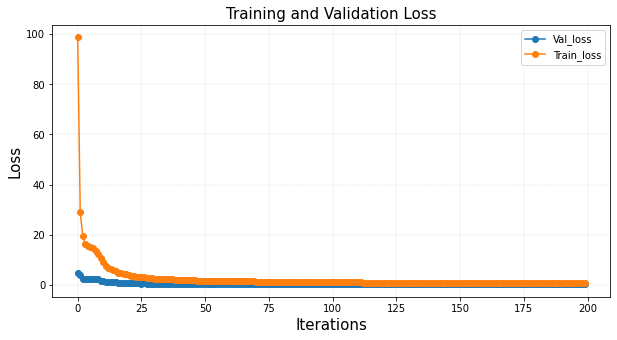

In [96]:
# plot the train and validation lossto monitor convergence
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss", fontsize = 15)
plt.plot(eval_losses, '-o', label="Val_loss")
plt.plot(train_losses, '-o', label="Train_loss")
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.2)
#plt.savefig('./loss.png')
plt.show()

In [97]:
# define the test loop
def test():
    model.eval()
    running_loss=0
    recon_test = []
    original_test = []
    hadamards_test = []
    with torch.no_grad():
        for X_test_inputs, X_test_target, X_test_original, hadamard_test in tqdm(test_dl):
            X_test_inputs, X_test_target, X_test_original, hadamard_test = X_test_inputs.cuda(), X_test_target.cuda(), X_test_original.cuda(), hadamard_test.cuda()
            recon=model(X_test_inputs.float())
            loss = loss_function(recon, X_test_target, hadamard_test) 
            running_loss+=loss.item()
            recon_test.append(recon.cpu().detach().numpy())
            original_test.append(X_test_original.cpu().detach().numpy())
            hadamards_test.append(hadamard_test.cpu().detach().numpy())            
        eval_loss=running_loss/len(test_dl)
        eval_losses.append(eval_loss)
    print('Validation Loss: %.3f' %(eval_loss))
    return recon_test, original_test, hadamards_test

In [98]:
recon_test, original_test, hadamards_test = test()

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 342.37it/s]

Validation Loss: 3.209


In [99]:
recon_test

[array([[0.0706559 , 0.96394736, 0.00744298, ..., 0.01659286, 0.02651689,
         0.02668702],
        [0.02215525, 0.96606714, 0.00992785, ..., 0.0276383 , 0.03019602,
         0.02983418],
        [0.03793986, 0.964726  , 0.00840427, ..., 0.02470801, 0.02882604,
         0.02914468],
        ...,
        [0.01801959, 0.9683055 , 0.00902107, ..., 0.01684883, 0.03360647,
         0.03276118],
        [0.03567467, 0.96512514, 0.00832825, ..., 0.06461067, 0.03296332,
         0.03259915],
        [0.0454215 , 0.96270543, 0.00892358, ..., 0.02085362, 0.02013561,
         0.02065969]], dtype=float32),
 array([[0.04496768, 0.9728434 , 0.0056752 , ..., 0.01566115, 0.03099193,
         0.03092029],
        [0.04465566, 0.9693365 , 0.00594993, ..., 0.01232666, 0.02901568,
         0.02888577],
        [0.02959924, 0.96818024, 0.01027961, ..., 0.08646523, 0.01750393,
         0.0176568 ],
        ...,
        [0.04109171, 0.9649992 , 0.00680106, ..., 0.08959524, 0.05631415,
         0.05523103

In [100]:
# Get the original as well as reconstructed datasets
recon_test = np.vstack(recon_test)
original_test = np.vstack(original_test)

In [101]:
hadamards_test = np.vstack(hadamards_test)

In [102]:
hadamards_test.shape, recon_test.shape

((868, 97), (868, 97))

In [103]:
recon_test

array([[0.0706559 , 0.96394736, 0.00744298, ..., 0.01659286, 0.02651689,
        0.02668702],
       [0.02215525, 0.96606714, 0.00992785, ..., 0.0276383 , 0.03019602,
        0.02983418],
       [0.03793986, 0.964726  , 0.00840427, ..., 0.02470801, 0.02882604,
        0.02914468],
       ...,
       [0.03978982, 0.96979374, 0.00985189, ..., 0.01841021, 0.02161818,
        0.02179526],
       [0.03640072, 0.96579206, 0.00796546, ..., 0.03461076, 0.04363717,
        0.04542131],
       [0.0636287 , 0.96648425, 0.00676153, ..., 0.01259684, 0.02568906,
        0.02548413]], dtype=float32)

In [104]:
# Fix the observed entries in the reconstructed set
recon_test[hadamards_test == 1.0] = original_test[hadamards_test == 1.0]

In [105]:
recon_test.shape, original_test.shape

((868, 97), (868, 97))

In [106]:
recon_test = pd.DataFrame(recon_test)

In [107]:
original_test = pd.DataFrame(original_test)

In [108]:
recon_test.columns = data_original.columns[:-1]

In [109]:
original_test.columns = data_original.columns[:-1]

In [110]:
recon_test = pd.DataFrame(recon_test)
recon_test.to_csv('C:\\Users\\16175\\Desktop\\recon_test.csv')

In [111]:
original_test = pd.DataFrame(original_test)
original_test.to_csv('C:\\Users\\16175\\Desktop\\original_test.csv')

In [112]:
# calculate the metrics on the unobserved entries of the tesset
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(original_test, recon_test)

In [113]:
rmse

0.0008197116441498121

In [114]:
hadamards_test = np.array(hadamards_test)

In [115]:
# Model evaluation calculate the metric on the unobserved entries of the test set this is relative absolute error. 
[r,c] = original_test.shape
hop = np.zeros((r*c))
ori = np.zeros((r*c))
meane = []
abse = []

##################################################################
	#  mean  and absolute hop error calculation----------------
print("-------------- Calculating error -----------------")

[r, c] = original_test.shape
        # vectorize matrices - placeholders
hop = []
ori = []

p = 0
for i in range(r):
    for j in range(c):
        if hadamards_test[i, j] == 0:  # considers error on only unobserved entries
            hop.append(recon_test[i, j])
            ori.append(original_test[i, j])
            p = p + 1

hop = np.array(hop)
ori = np.array(ori)
x = np.round(hop - ori)

print ("numerator:", np.sum(abs(x)))
print ("sum of unobserved entries:", np.sum(ori))
print ("b: total unobserved entries:", len(ori))

mean_err = (np.sum(abs(x))) / (np.sum(ori))
mean_err = mean_err * 100
mean_std = np.std(abs(x))

abs_err = (np.sum(abs(x))) / (len(ori))  # divided by the number of unobserved entries
abs_std = np.std(abs(x))

print(mean_err)
print(abs_err)

-------------- Calculating error -----------------


KeyError: (0, 3)